In [5]:
import tensorflow as tf
import qresnet
import dataset
from tensorflow import keras
from keras import layers
from qkeras import *

In [6]:
x_train, y_train, x_test, y_test = dataset.load_cifar10()

(50000, 1)


In [7]:
x = x_in = layers.Input(x_train.shape[1:], name="input")
x = QActivation(quantized_relu_po2(4,1,use_stochastic_rounding=True))(x)
x = qresnet.resnet32(x, num_classes=10)
qmodel = keras.Model(inputs=[x_in], outputs=[x])
qmodel.summary()

c:\Users\georg\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\initializers\initializers_v2.py:120: UserWarning: The initializer HeNormal is unseeded and being called multiple times, which will return identical values  each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initalizer instance more than once.
  warnings.warn(


Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input (InputLayer)             [(None, 32, 32, 3)]  0           []                               
                                                                                                  
 q_activation (QActivation)     (None, 32, 32, 3)    0           ['input[0][0]']                  
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 34, 34, 3)    0           ['q_activation[0][0]']           
                                                                                                  
 qconv1 (QConv2D)               (None, 32, 32, 16)   432         ['conv1_pad[0][0]']              
                                                                                            

In [8]:
class ResNetPaperLR(tf.keras.optimizers.schedules.LearningRateSchedule):
    def __init__(self, initial_lr = 0.1, learning_rate_decay=10, steps=[32000, 48000]):
        super(ResNetPaperLR, self).__init__()
        self.initial_lr = initial_lr
        self.learning_rate_decay = learning_rate_decay
        self.steps = steps
        self.current_lr = 0
    def __call__(self, step):        
        step12 = tf.where(step < self.steps[1], self.initial_lr/self.learning_rate_decay, self.initial_lr/(self.learning_rate_decay**2))    
        step01 = tf.where(step < self.steps[0], self.initial_lr, step12)
        return step01
                         

    def get_config(self):
        return {
            "initial_lr": self.initial_lr,
            "learning_rate_decay": self.learning_rate_decay,
            "steps": self.steps
        }


NB_EPOCH = 164
BATCH_SIZE = 128
VERBOSE = 1

OPTIMIZER = keras.optimizers.Adam(learning_rate=ResNetPaperLR(0.001), decay=0.000025)

qmodel.compile(optimizer=OPTIMIZER, loss=keras.losses.CategoricalCrossentropy(from_logits=True, label_smoothing=0.02), metrics=["accuracy"])


In [9]:
history = qmodel.fit(x_train, y_train, batch_size=BATCH_SIZE, epochs=NB_EPOCH, initial_epoch=0, verbose=VERBOSE, validation_data=(x_test, y_test), validation_freq=2)


Epoch 1/164
391/391 [==============================] - 75s 131ms/step - loss: 2.2691 - accuracy: 0.1322
Epoch 2/164
391/391 [==============================] - 64s 164ms/step - loss: 2.1284 - accuracy: 0.2189 - val_loss: 2.2647 - val_accuracy: 0.1644
Epoch 3/164
391/391 [==============================] - 51s 130ms/step - loss: 2.0940 - accuracy: 0.2353
Epoch 4/164
391/391 [==============================] - 58s 147ms/step - loss: 2.0016 - accuracy: 0.2709 - val_loss: 1.9935 - val_accuracy: 0.2775
Epoch 5/164
391/391 [==============================] - 51s 130ms/step - loss: 1.9293 - accuracy: 0.3009
Epoch 6/164
391/391 [==============================] - 58s 147ms/step - loss: 1.8783 - accuracy: 0.3194 - val_loss: 2.0200 - val_accuracy: 0.2914
Epoch 7/164
391/391 [==============================] - 51s 131ms/step - loss: 1.8332 - accuracy: 0.3412
Epoch 8/164
391/391 [==============================] - 58s 148ms/step - loss: 1.7850 - accuracy: 0.3603 - val_loss: 1.7673 - val_accuracy: 0.3647


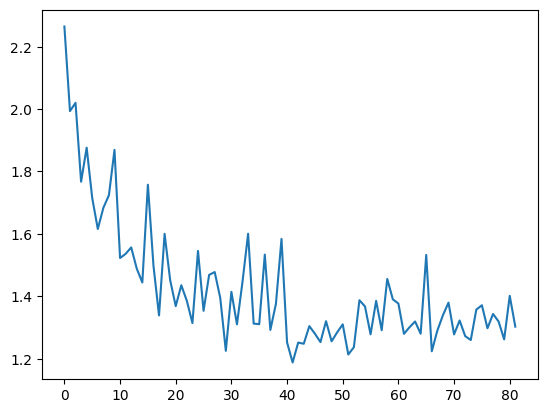

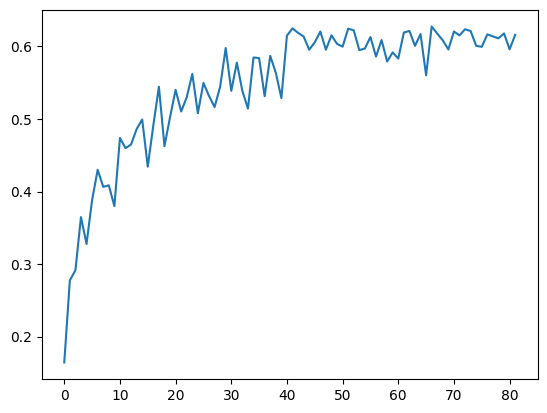

In [10]:
import matplotlib.pyplot as plt


#plt.plot(history.history["loss"])
plt.plot(history.history["val_loss"])
plt.show()    
#plt.plot(history.history["accuracy"])
plt.plot(history.history["val_accuracy"])
plt.show()    

In [14]:
from qkeras.utils import model_save_quantized_weights, load_qmodel


dic = model_save_quantized_weights(qmodel, "qmodels/resnet32/qmodel_weights")
dic = model_save_quantized_weights(qmodel, "qmodels/resnet32/qmodel_weights.h5")
qmodel.save("qmodels/resnet32/model.h5")
qmodel_load_test = load_qmodel("qmodels/resnet32/model.h5", custom_objects={"ResNetPaperLR":ResNetPaperLR})
qmodel_load_test.evaluate(x_test, y_test)


... quantizing model
... quantizing model


c:\Users\georg\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\initializers\initializers_v2.py:120: UserWarning: The initializer HeNormal is unseeded and being called multiple times, which will return identical values  each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initalizer instance more than once.
  warnings.warn(


TypeError: ResNetPaperLR.__init__() got an unexpected keyword argument 'learning_rate_decay'

In [11]:
print_qstats(qmodel)

c:\Users\georg\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\initializers\initializers_v2.py:120: UserWarning: The initializer HeNormal is unseeded and being called multiple times, which will return identical values  each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initalizer instance more than once.
  warnings.warn(


Instructions for updating:
Use ref() instead.


Instructions for updating:
Use ref() instead.



Number of operations in model:
    fc                            : 640   (sadder_4_4)
    qconv1                        : 442368 (sadder_4_4)
    qlayer1.0.conv1               : 2359296 (sadder_4_4)
    qlayer1.0.conv2               : 2359296 (sadder_4_4)
    qlayer1.1.conv1               : 2359296 (sadder_4_4)
    qlayer1.1.conv2               : 2359296 (sadder_4_4)
    qlayer1.2.conv1               : 2359296 (sadder_4_4)
    qlayer1.2.conv2               : 2359296 (sadder_4_4)
    qlayer1.3.conv1               : 2359296 (sadder_4_4)
    qlayer1.3.conv2               : 2359296 (sadder_4_4)
    qlayer1.4.conv1               : 2359296 (sadder_4_4)
    qlayer1.4.conv2               : 2359296 (sadder_4_4)
    qlayer2.0.conv1               : 1179648 (sadder_4_4)
    qlayer2.0.conv2               : 2359296 (sadder_4_4)
    qlayer2.0.downsample.0        : 131072 (sadder_4_4)
    qlayer2.1.conv1               : 2359296 (sadder_4_4)
    qlayer2.1.conv2               : 2359296 (sadder_4_4)
   